In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
%matplotlib inline

import tensorflow as tf  # Importing the TensorFlow Library
from tensorflow import keras  # Import Keras from TensorFlow
from tensorflow.keras import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import datetime


import glob
import cv2

In [3]:
cd /content/drive/My Drive/Colab Notebooks/kaggle_dog_cat

/content/drive/My Drive/Colab Notebooks/kaggle_dog_cat


In [4]:
!unzip  dog_cat.zip

Streaming output truncated to the last 5000 lines.
  inflating: dog_cat/train/cat.37.jpg  
  inflating: dog_cat/train/cat.370.jpg  
  inflating: dog_cat/train/cat.3700.jpg  
  inflating: dog_cat/train/cat.3701.jpg  
  inflating: dog_cat/train/cat.3702.jpg  
  inflating: dog_cat/train/cat.3703.jpg  
  inflating: dog_cat/train/cat.3704.jpg  
  inflating: dog_cat/train/cat.3705.jpg  
  inflating: dog_cat/train/cat.3706.jpg  
  inflating: dog_cat/train/cat.3707.jpg  
  inflating: dog_cat/train/cat.3708.jpg  
  inflating: dog_cat/train/cat.3709.jpg  
  inflating: dog_cat/train/cat.371.jpg  
  inflating: dog_cat/train/cat.3710.jpg  
  inflating: dog_cat/train/cat.3711.jpg  
  inflating: dog_cat/train/cat.3712.jpg  
  inflating: dog_cat/train/cat.3713.jpg  
  inflating: dog_cat/train/cat.3714.jpg  
  inflating: dog_cat/train/cat.3715.jpg  
  inflating: dog_cat/train/cat.3716.jpg  
  inflating: dog_cat/train/cat.3717.jpg  
  inflating: dog_cat/train/cat.3718.jpg  
  inflating: dog_cat/train/ca

In [5]:
import os
filenames = os.listdir("/content/drive/MyDrive/Colab Notebooks/kaggle_dog_cat/dog_cat/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [6]:
df.tail()

,filename,category
7995,dog.995.jpg,1
7996,dog.996.jpg,1
7997,dog.997.jpg,1
7998,dog.998.jpg,1
7999,dog.999.jpg,1


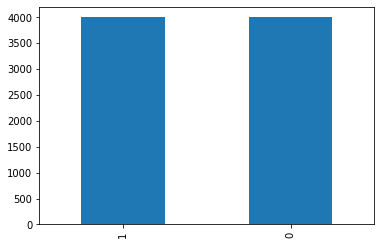

In [7]:
df['category'].value_counts().plot.bar()

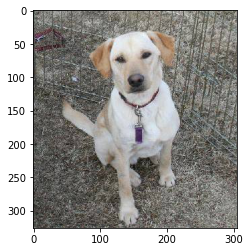

In [8]:
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/Colab Notebooks/kaggle_dog_cat/dog_cat/train/"+sample)
plt.imshow(image)

In [9]:
training_images = []
for img in glob.glob("/content/drive/MyDrive/Colab Notebooks/kaggle_dog_cat/dog_cat/train/*.jpg"):
     n = cv2.imread(img)
     training_images.append(n)

In [10]:
testing_images = []
for img in glob.glob("/content/drive/MyDrive/Colab Notebooks/kaggle_dog_cat/dog_cat/test/*.jpg"):
     n = cv2.imread(img)
     testing_images.append(n)

In [11]:
len(training_images)

8000

In [12]:
len(df)

8000

In [32]:
path1=r"/content/drive/MyDrive/Colab Notebooks/kaggle_dog_cat/dog_cat/train/"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

    
images = [[fname, path1+ fname] for fname in df['filename']]
train_df = pd.DataFrame(images)
train_df.columns = ['image_id', 'file']
train_df['category']=df['category']

In [33]:
train_df['file'][0]

'/content/drive/MyDrive/Colab Notebooks/kaggle_dog_cat/dog_cat/train/cat.1.jpg'

In [34]:
images_train=[]
for img in train_df['file']:
    img=cv2.imread(img)
    img = cv2.resize(img, (128,128),interpolation=cv2.INTER_CUBIC)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    images_train.append(img)

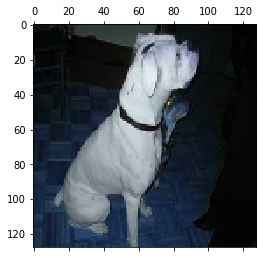

In [35]:
images_train=np.array(images_train)
plt.matshow(images_train[5000])

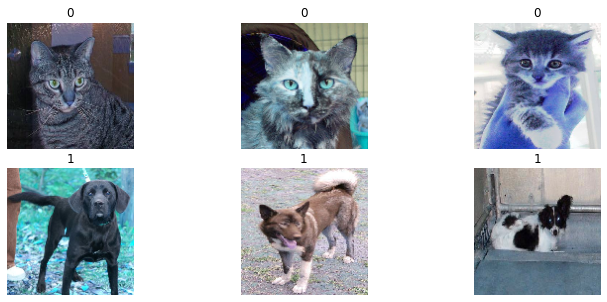

In [36]:
num_rows, num_cols = 2,3
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),
                     gridspec_kw={'wspace':0.15, 'hspace':0.15}, 
                     squeeze=True)

for r in range(num_rows):
    for c in range(num_cols):
      
        image_index = r*5500 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(images_train[image_index], cmap='gray')
        ax[r,c].set_title(train_df['category'][image_index])
plt.show()
plt.close()

In [37]:
images_train.shape

(8000, 128, 128, 3)

In [38]:
# define input shape
INPUT_SHAPE = (128,128,3)

# get the densenet169 model
vgg_layers = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE)
# ignore the variable name as vgg_layers as I reused my first code for all the other models by changing the pretrained modelsto check how each pretrained models work

#print the summary and architecture of densenet169 layers
vgg_layers.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [39]:
# Fine-tune all the layers
for layer in vgg_layers.layers:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f26423a6f28> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f26a604e0f0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f26a602cc50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f26a6194320> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f26a61df978> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2625f833c8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f264230fd68> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2642327080> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2642327eb8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f264232d2b0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f264232dba8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [40]:
import random
from tensorflow.keras.optimizers import Adam

# define sequential model
model = tf.keras.models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_layers)

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
#model.add(tf.keras.layers.Dropout(rate=0.1))
model.add(tf.keras.layers.Dense(256, activation='relu'))
#model.add(tf.keras.layers.Dropout(rate=0.1))


# add output layer
model.add(tf.keras.layers.Dense(2, activation='softmax'))

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 16,878,402
Trainable params: 2,163,714
Non-trainable params: 14,714,688
_________________________________________________________________


In [41]:
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(train_df, test_size=0.10, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [42]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=16

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.1
)

In [44]:
train_df["category"] = train_df["category"].replace({0: 'cat', 1: 'dog'}) 

In [45]:
validate_df["category"] = validate_df["category"].replace({0: 'cat', 1: 'dog'}) 

In [46]:
train_generator = train_datagen.flow_from_dataframe(train_df,r'/content/drive/MyDrive/Colab Notebooks/kaggle_dog_cat/dog_cat/train/',
                                      x_col='file',y_col='category',class_mode='categorical',
                                   batch_size=16, target_size=(128,128),shuffle=False)

Found 7200 validated image filenames belonging to 2 classes.


In [47]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    r'/content/drive/MyDrive/Colab Notebooks/kaggle_dog_cat/dog_cat/train/',x_col='file',y_col='category',class_mode='categorical',
                                   batch_size=16, target_size=(128,128),shuffle=False)

Found 800 validated image filenames belonging to 2 classes.


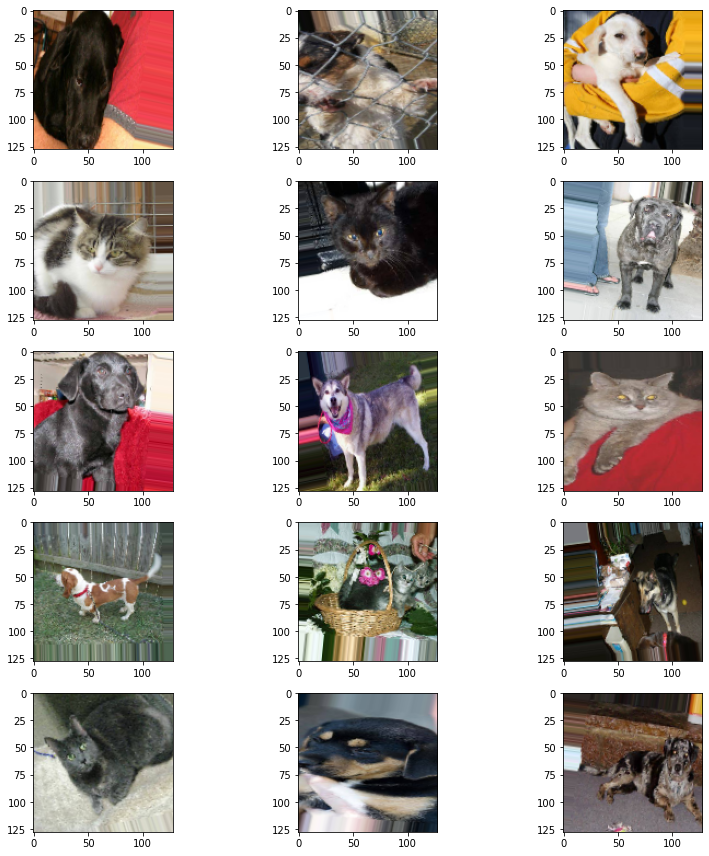

In [48]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [49]:
EPOCHS = 100

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[es_callback]
)

Epoch 1/100
450/450 [==============================] - 54s 120ms/step - loss: 0.4804 - accuracy: 0.7693 - val_loss: 0.3346 - val_accuracy: 0.8550
Epoch 2/100
450/450 [==============================] - 54s 120ms/step - loss: 0.3610 - accuracy: 0.8439 - val_loss: 0.3024 - val_accuracy: 0.8650
Epoch 3/100
450/450 [==============================] - 54s 120ms/step - loss: 0.3382 - accuracy: 0.8517 - val_loss: 0.2759 - val_accuracy: 0.8775
Epoch 4/100
450/450 [==============================] - 54s 120ms/step - loss: 0.3249 - accuracy: 0.8603 - val_loss: 0.2755 - val_accuracy: 0.8813
Epoch 5/100
450/450 [==============================] - 54s 121ms/step - loss: 0.3083 - accuracy: 0.8692 - val_loss: 0.2595 - val_accuracy: 0.8838
Epoch 6/100
450/450 [==============================] - 54s 120ms/step - loss: 0.3049 - accuracy: 0.8696 - val_loss: 0.2510 - val_accuracy: 0.8800
Epoch 7/100
450/450 [==============================] - 54s 119ms/step - loss: 0.2892 - accuracy: 0.8736 - val_loss: 0.2622 -

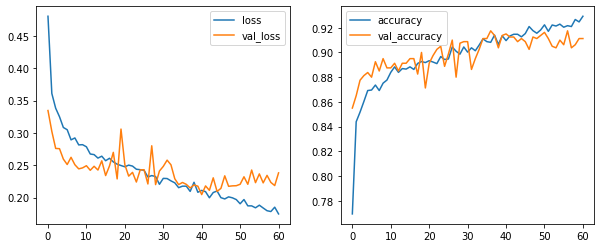

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [55]:
path2=r"/content/drive/MyDrive/Colab Notebooks/kaggle_dog_cat/dog_cat/test/"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import os
test_filenames = os.listdir("/content/drive/MyDrive/Colab Notebooks/kaggle_dog_cat/dog_cat/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
test_df.info()

images = [[fname,path2+ fname] for fname in test_df['filename']]
test_df = pd.DataFrame(images)
test_df.columns = ['image_id', 'file']
test_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  10 non-null     object
dtypes: object(1)
memory usage: 208.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  10 non-null     object
 1   file      10 non-null     object
dtypes: object(2)
memory usage: 288.0+ bytes


In [56]:
images_test=[]
for img in test_df['file']:
    img=cv2.imread(img)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128,128),interpolation=cv2.INTER_CUBIC)
    images_test.append(img)

In [ ]:
images_test=np.array(images_test)
plt.matshow(images_test[1])

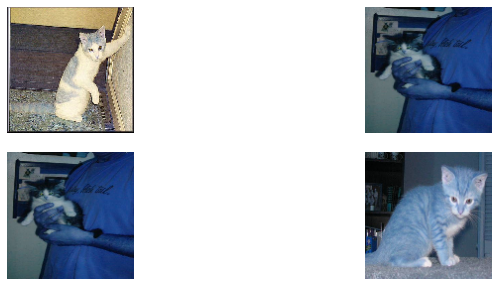

In [58]:
num_rows, num_cols = 2,2
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),
                     gridspec_kw={'wspace':0.15, 'hspace':0.15}, 
                     squeeze=True)

for r in range(num_rows):
    for c in range(num_cols):
      
        image_index = r*1 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(images_test[image_index], cmap='gray')
        
plt.show()
plt.close()

In [62]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/Colab Notebooks/kaggle_dog_cat/dog_cat/test/", 
    x_col='file',
    y_col=None,
    class_mode=None,
    target_size=(128,128),
    batch_size=batch_size,
    shuffle=False
)

Found 10 validated image filenames.


In [63]:
# X_test_flattened=images_test/255
y_predict=model.predict(test_generator)

In [65]:
test_df['category'] = np.argmax(y_predict, axis=-1)

In [66]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

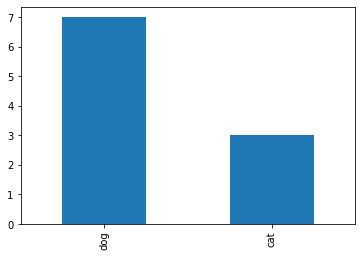

In [67]:
test_df['category'].value_counts().plot.bar()

In [68]:
print(label_map)

{0: 'cat', 1: 'dog'}


In [69]:
test_df.head(10)

,image_id,file,category
0,cat.4001.jpg,/content/drive/MyDrive/Colab Notebooks/kaggle_...,dog
1,cat.4002.jpg,/content/drive/MyDrive/Colab Notebooks/kaggle_...,dog
2,cat.4003.jpg,/content/drive/MyDrive/Colab Notebooks/kaggle_...,cat
3,cat.4004.jpg,/content/drive/MyDrive/Colab Notebooks/kaggle_...,cat
4,cat.4005.jpg,/content/drive/MyDrive/Colab Notebooks/kaggle_...,cat
5,dog.4006.jpg,/content/drive/MyDrive/Colab Notebooks/kaggle_...,dog
6,dog.4007.jpg,/content/drive/MyDrive/Colab Notebooks/kaggle_...,dog
7,dog.4008.jpg,/content/drive/MyDrive/Colab Notebooks/kaggle_...,dog
8,dog.4009.jpg,/content/drive/MyDrive/Colab Notebooks/kaggle_...,dog
9,dog.4010.jpg,/content/drive/MyDrive/Colab Notebooks/kaggle_...,dog
